## <center> **Практика. Статистические тесты в контексте EDA**

## <center> *Исследование данных HR-агентства*

### **Постановка задачи**

К Вам, как к опытному дата-сайентисту, обратилось HR-агенство, которое изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере *Data Science* за 2020-2022 годы и получить некоторые выводы.

HR-агенство хочет ответить на следующие вопросы, касающиеся зарплат в сфере *Data Science*:

**1.** Какие факторы влияют на зарплату специалиста *Data Scientist*.

**2.** А также ответить на следующие ключевые вопросы:
    
* Наблюдается ли ежегодный рост зарплат у специалистов *Data Scientist*?
* Как соотносятся зарплаты *Data Scientist* и *Data Engineer* в 2022 году?
* Как соотносятся зарплаты специалистов *Data Scientist* в компаниях различных размеров?
* Есть ли связь между наличием должностей *Data Scientist* и *Data Engineer* и размером компании?

Необходимо найти в данных интересные закономерности, также отметить их в своём анализе.

Продемонстрировать использование разных тестов для проверки статистической значимости сделанных выводов:

* тесты для количественного признака:
    * для одной выборки;
    * для двух выборок;
    * для нескольких выборок;
* тест для категориальных признаков.

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на эти вопросы помогут данные о выплатах зарплат специалистам в сфере *Data Science*.

Данные содержат следующие столбцы:

<img src="images/Данные о выплатах зарплат специалистам в сфере DS.png">

Источник датасета: ["Data Science Job Salaries" (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

#### **1. Загрузка и обработка данных**

In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# Делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2")

# Для отключения всех предупреждений
import warnings
warnings.filterwarnings('ignore')

* **Необходимо корректно загрузить данные.**

In [87]:
# Скачиваем датасет 
import wget
wget.download ("https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@ds_salaries.zip", 'ds_salaries.zip')

'ds_salaries.zip'

In [2]:
# Загружаем датасет
df_salaries = pd.read_csv('./ds_salaries.csv', index_col=0)
# Выведем первые пять строк таблицы с помощью head()
display(df_salaries.head())

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
# Выведем последние пять строк таблицы с помощью tail()
display(df_salaries.tail())

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M
606,2022,MI,FT,AI Scientist,200000,USD,200000,IN,100,US,L


* **Проверим датасет на наличие пропусков и дубликатов, а также на корректность типов данных столбцов.**

In [4]:
df_salaries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [5]:
# Проверяем наличие дубликатов
print("Количество дубликатов: {}".format(df_salaries[df_salaries.duplicated()].shape[0]))

# Удаляем дубликаты
df_salaries = df_salaries.drop_duplicates()
print("Размер таблицы после удаления дубликатов: {}".format(df_salaries.shape[0]))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: 565


* **Определим в данных неинформативные признаки, которые не будут участвовать в исследовании.**

In [6]:
# Список неинформативных признаков
low_information_cols = [] 

# Цикл по всем столбцам
for col in df_salaries.columns:
    # Наибольшая относительная частота в признаке
    top_freq = df_salaries[col].value_counts(normalize=True).max()
    # Доля уникальных значений от размера признака
    nunique_ratio = df_salaries[col].nunique() / df_salaries[col].count()
    # Сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f"{col}: {round(top_freq*100, 2)}% одинаковых значений")
    # Сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f"{col}: {round(nunique_ratio*100, 2)}% уникальных значений")

employment_type: 96.64% одинаковых значений


Итак, мы нашли один неинформативный признак. Теперь можно удалить его с помощью метода **drop(),** передав результирующий список в его аргументы.

In [7]:
information_df_salaries = df_salaries.drop(low_information_cols, axis=1)
print(f"Результирующее число признаков: {information_df_salaries.shape[1]}")
display(information_df_salaries)

Результирующее число признаков: 10


,work_year,experience_level,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,Data Analyst,150000,USD,150000,US,100,US,M


Также удалим еще два признака, которые не будут участвовать в исследовании: *salary* и *salary_currency* - они отвечают за размер зарплаты и ее валюту, но так как в датасете уже есть признак *salary_in_usd* мы и будем им пользоваться.

In [8]:
information_df_salaries.drop(["salary", "salary_currency"], axis=1, inplace=True)
display(information_df_salaries)

,work_year,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,Data Scientist,79833,DE,0,DE,L
1,2020,SE,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,Machine Learning Engineer,150000,US,50,US,L
...,...,...,...,...,...,...,...,...
602,2022,SE,Data Engineer,154000,US,100,US,M
603,2022,SE,Data Engineer,126000,US,100,US,M
604,2022,SE,Data Analyst,129000,US,0,US,M
605,2022,SE,Data Analyst,150000,US,100,US,M


Создадим копию *DataFrame* после удаления неинформативного признака с помощью метода **copy():**

In [9]:
df_salaries_1 = information_df_salaries.copy()

* **Классифицируем все признаки на *числовые* и *категориальные*.**

In [10]:
categorical = df_salaries_1.select_dtypes(object).columns
numeric = df_salaries_1.select_dtypes(exclude = object).columns
print(len(categorical), "категориальных признаков:", categorical)
print(len(numeric), "числовых признака:", numeric)

5 категориальных признаков: Index(['experience_level', 'job_title', 'employee_residence',
       'company_location', 'company_size'],
      dtype='object')
3 числовых признака: Index(['work_year', 'salary_in_usd', 'remote_ratio'], dtype='object')


* **Найти основные статистические характеристики для каждого из признаков.**

In [11]:
df_salaries_1.describe(include="all")

,work_year,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,565.000000,565,565,565.000000,565,565.000000,565,565
unique,NaN,4,50,NaN,57,NaN,50,3
top,NaN,SE,Data Scientist,NaN,US,NaN,US,M
freq,NaN,243,130,NaN,295,NaN,318,290
mean,2021.364602,NaN,NaN,110610.343363,NaN,69.911504,NaN,NaN
std,0.698138,NaN,NaN,72280.702792,NaN,40.900666,NaN,NaN
min,2020.000000,NaN,NaN,2859.000000,NaN,0.000000,NaN,NaN
25%,2021.000000,NaN,NaN,60757.000000,NaN,50.000000,NaN,NaN
50%,2021.000000,NaN,NaN,100000.000000,NaN,100.000000,NaN,NaN
75%,2022.000000,NaN,NaN,150000.000000,NaN,100.000000,NaN,NaN


#### **2. Разведывательный анализ данных**

In [12]:
# Задаем уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


##### **2.1. Визуальный анализ данных**

Итак, далее сформулируем следующие ключевые вопросы и ответим на них, проверив ответы на статистическую значимость.

**1. Наблюдается ли ежегодный рост зарплат у специалистов *Data Scientist*?**

In [13]:
data_scientist = df_salaries_1[df_salaries_1["job_title"] == "Data Scientist"]
data_agg = data_scientist.groupby("work_year")["salary_in_usd"].describe().round(2)
print("Размер зарплатных выплат специалистов Data Scientist в зависимости от года")
data_agg

Размер зарплатных выплат специалистов Data Scientist в зависимости от года


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.00,62726.0,105000.00,412000.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


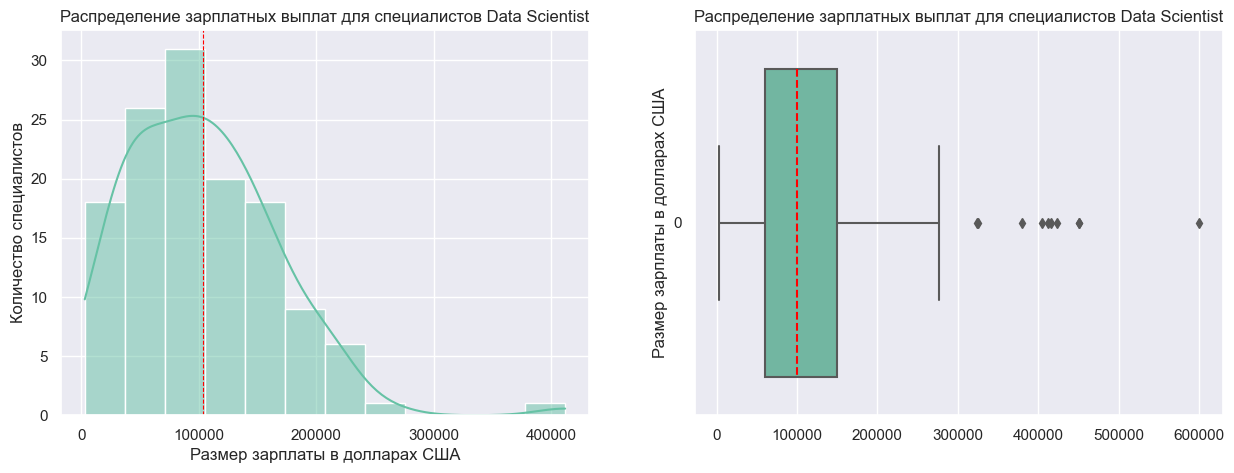

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data_scientist["salary_in_usd"], kde=True, ax=axes[0])
axes[0].set(xlabel="Размер зарплаты в долларах США", ylabel="Количество специалистов")
axes[0].set_title("Распределение зарплатных выплат для специалистов Data Scientist")
axes[0].axvline(data_scientist["salary_in_usd"].mean(), color="red", linestyle="--", linewidth=0.8)

sns.boxplot(df_salaries["salary_in_usd"], ax=axes[1], orient="h", medianprops={"color": "red", "linestyle": "--"})
axes[1].set(ylabel="Размер зарплаты в долларах США")
axes[1].set_title("Распределение зарплатных выплат для специалистов Data Scientist")

plt.show()


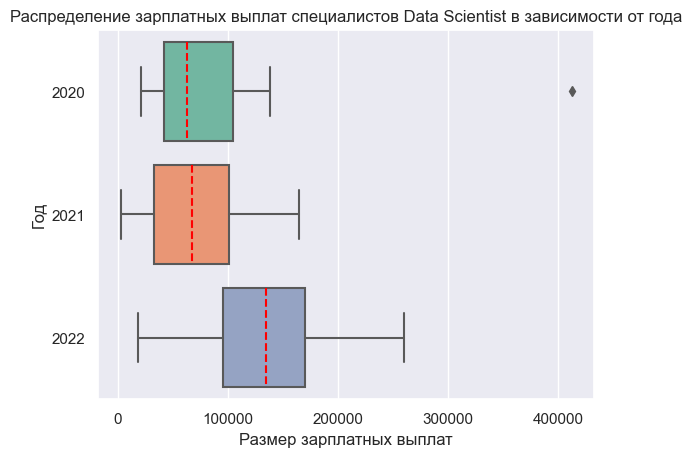

In [15]:
ax = sns.boxplot(data_scientist, x="salary_in_usd", y="work_year", orient="h", medianprops={"color": "red", "linestyle": "--"})
ax.set(xlabel="Размер зарплатных выплат", ylabel="Год")
plt.title("Распределение зарплатных выплат специалистов Data Scientist в зависимости от года")
plt.show()

Как можно заметить, распределение размера заработных выплат специалистов *Data Scientist* в зависиости от года отличается друг от друга, но в целом наблюдается рост зарплат из года в год. Чтобы определить, являются ли эти отличия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

**2. Как соотносятся зарплаты *Data Scientist* и *Data Engineer* в 2022 году?**

In [16]:
data_scientist = df_salaries_1[(df_salaries_1["job_title"] == "Data Scientist") & (df_salaries["work_year"].isin([2022]))]
data_agg_ds = data_scientist.groupby("work_year")["salary_in_usd"].describe().round(2)
print("Соотношение зарплат специалистов Data Scientist и Data Engineer в 2022 году")

data_engineer = df_salaries_1[(df_salaries_1["job_title"] == "Data Engineer") & (df_salaries["work_year"].isin([2022]))]
data_agg_de = data_engineer.groupby("work_year")["salary_in_usd"].describe().round(2)

display(data_agg_ds, data_agg_de)

Соотношение зарплат специалистов Data Scientist и Data Engineer в 2022 году


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2022,65.0,131366.94,55785.24,18442.0,95550.0,135000.0,170000.0,260000.0


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2022,79.0,124651.78,57846.84,25000.0,78526.0,115000.0,160040.0,324000.0


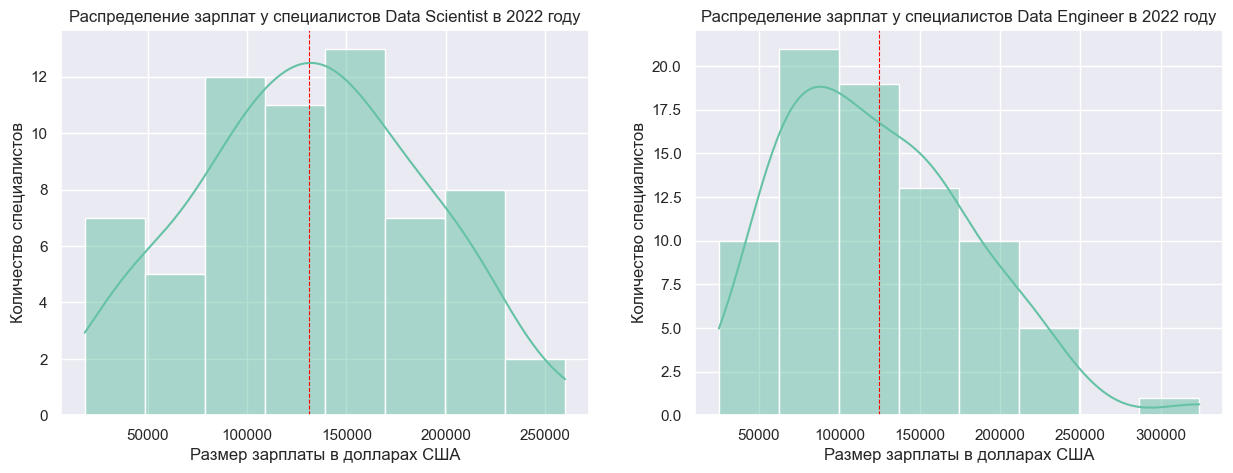

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data_scientist["salary_in_usd"], kde=True, ax=axes[0])
axes[0].set(xlabel="Размер зарплаты в долларах США", ylabel="Количество специалистов")
axes[0].set_title("Распределение зарплат у специалистов Data Scientist в 2022 году")
axes[0].axvline(data_scientist["salary_in_usd"].mean(), color="red", linestyle="--", linewidth=0.8)

sns.histplot(data_engineer["salary_in_usd"], kde=True, ax=axes[1])
axes[1].set(xlabel="Размер зарплаты в долларах США", ylabel="Количество специалистов")
axes[1].set_title("Распределение зарплат у специалистов Data Engineer в 2022 году")
axes[1].axvline(data_engineer["salary_in_usd"].mean(), color="red", linestyle="--", linewidth=0.8)

plt.show()

Обратя внимание, можно заметить, что распределение зарплатных выплат в 2022 году у специалистов *Data Scientist* меньше, чем у специалистов *Data Engineer*. Чтобы определить, являются ли эти отличия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

**3. Как соотносятся зарплаты специалистов *Data Scientist* в компаниях различных размеров?**

In [18]:
data_scientist = df_salaries_1[(df_salaries_1["job_title"] == "Data Scientist")]
data_agg = data_scientist.groupby("company_size")["salary_in_usd"].describe().round(2)
print("Соотношение зарплат специалистов Data Scientist в зависимости от размера компаний")
data_agg

Соотношение зарплат специалистов Data Scientist в зависимости от размера компаний


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,43.0,102743.42,73254.10,13400.0,45240.5,90734.0,135000.0,412000.0
M,66.0,120080.58,56347.79,4000.0,80000.0,119529.5,157500.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


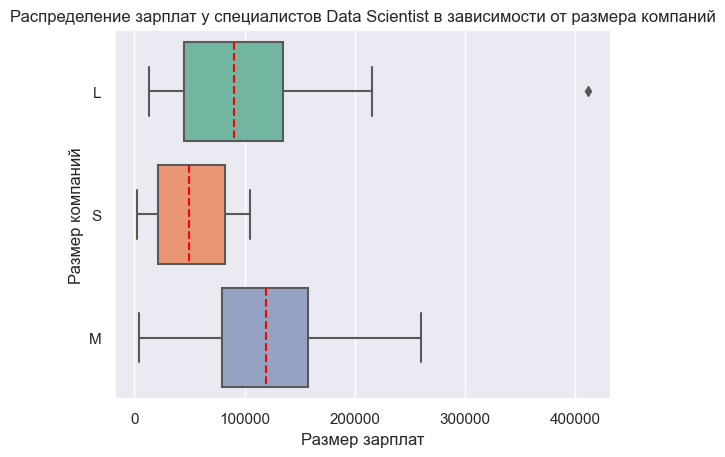

In [19]:
ax = sns.boxplot(data_scientist, x="salary_in_usd", y="company_size", orient="h", medianprops={"color": "red", "linestyle": "--"})
ax.set(xlabel="Размер зарплат", ylabel="Размер компаний")
plt.title("Распределение зарплат у специалистов Data Scientist в зависимости от размера компаний")
plt.show()

Итак, распределение зарплат у специалистов *Data Scientist* в зависимости от размера компаний имеют отличия. Чтобы определить, являются ли эти отличия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

**4. Есть ли связь между наличием должностей *Data Scientist* и *Data Engineer* и размером компании?**

In [20]:
data_scientist = df_salaries_1[(df_salaries_1["job_title"] == "Data Scientist")]
data_agg_ds = data_scientist.groupby("company_size")["experience_level"].describe().round(2)
print("Взаимосвязь вакансий Data Scientist и Data Engineer от опыта работы и размера компаний")

data_engineer = df_salaries_1[(df_salaries_1["job_title"] == "Data Engineer")]
data_agg_de = data_engineer.groupby("company_size")["experience_level"].describe().round(2)

display(data_agg_ds, data_agg_de)

Взаимосвязь вакансий Data Scientist и Data Engineer от опыта работы и размера компаний


,count,unique,top,freq
company_size,,,,
L,43,3,MI,22
M,66,3,SE,32
S,21,3,MI,12


,count,unique,top,freq
company_size,,,,
L,34,3,MI,20
M,81,4,SE,41
S,6,3,SE,3


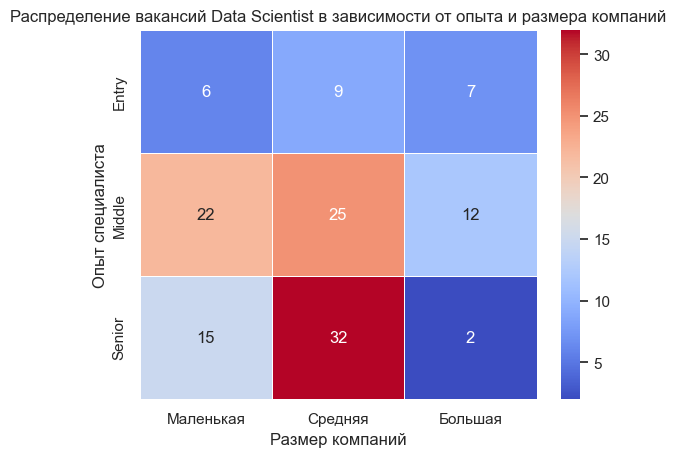

In [21]:
cross_tab = pd.crosstab(index=data_scientist["experience_level"], columns=df_salaries["company_size"])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt=".0f", cmap="coolwarm")
ax.set(xlabel="Размер компаний", ylabel="Опыт специалиста")
ax.set_xticklabels(["Маленькая", "Средняя", "Большая"])
ax.set_yticklabels(["Entry", "Middle", "Senior"])
plt.title("Распределение вакансий Data Scientist в зависимости от опыта и размера компаний")
plt.show()

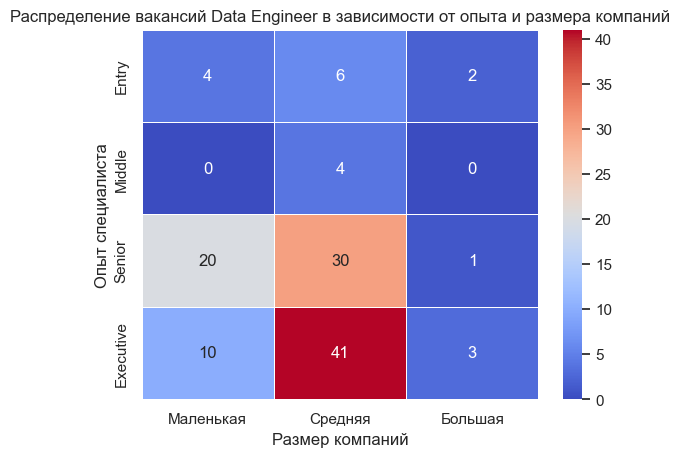

In [22]:
cross_tab = pd.crosstab(index=data_engineer["experience_level"], columns=df_salaries["company_size"])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt=".0f", cmap="coolwarm")
ax.set(xlabel="Размер компаний", ylabel="Опыт специалиста")
ax.set_xticklabels(["Маленькая", "Средняя", "Большая"])
ax.set_yticklabels(["Entry", "Middle", "Senior", "Executive"])
plt.title("Распределение вакансий Data Engineer в зависимости от опыта и размера компаний")
plt.show()

Как можно отметить, распределение вакансий специалистов *Data Scientist* и *Data Engineer* в зависимости от опыта и размера компаний однозначно имеют отличия. Чтобы определить, являются ли эти отличия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

#### **Дополнительные исследования:**

**5. Также, хотелось бы в целом определить ежегодный рост зарплатных выплат.**

In [23]:
data_agg = df_salaries_1.groupby("work_year")["salary_in_usd"].describe().round(2)
print("Распределение зарплатных выплат в зависимости от года")
data_agg

Распределение зарплатных выплат в зависимости от года


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,215.0,99430.41,80304.32,2859.0,50000.0,82528.0,135000.0,600000.0
2022,278.0,123089.10,59888.93,10000.0,78791.0,120000.0,160000.0,405000.0


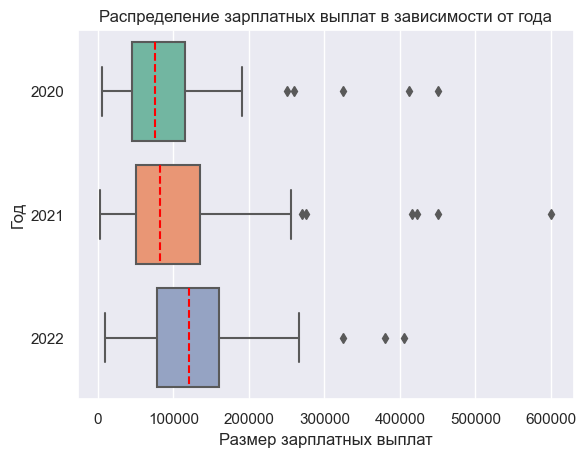

In [24]:
ax = sns.boxplot(df_salaries_1, x="salary_in_usd", y="work_year", orient="h", medianprops={"color": "red", "linestyle": "--"})
ax.set(xlabel="Размер зарплатных выплат", ylabel="Год")
plt.title("Распределение зарплатных выплат в зависимости от года")
plt.show()

Распределения зарплатных выплат в зависимости от года имеют отличия. Чтобы определить, являются ли эти отличия статистически значимыми, необходимо провести статистическое тестирование.

**6. Распределение зарплатных выплат в зависимости от опыта работы.**

In [25]:
data_agg = df_salaries_1.groupby("experience_level")["salary_in_usd"].describe().round(2)
print("Распределение зарплатных выплат в зависимости от опыта работы")
data_agg

Распределение зарплатных выплат в зависимости от опыта работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.32,44395.54,4000.0,27505.00,56500.0,85425.75,250000.0
EX,26.0,199392.04,117071.26,69741.0,130006.50,171437.5,233750.00,600000.0
MI,208.0,87793.00,64118.97,2859.0,47163.75,76940.0,112075.00,450000.0
SE,243.0,138374.88,59955.97,18907.0,99531.50,135000.0,171881.00,412000.0


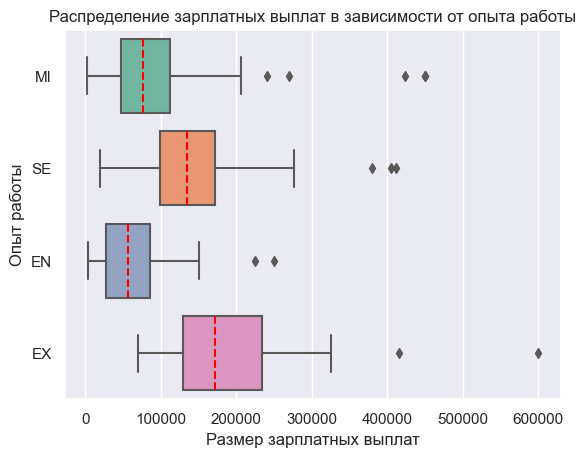

In [26]:
ax = sns.boxplot(df_salaries_1, x="salary_in_usd", y="experience_level", orient="h", medianprops={"color": "red", "linestyle": "--"})
ax.set(xlabel="Размер зарплатных выплат", ylabel="Опыт работы")
plt.title("Распределение зарплатных выплат в зависимости от опыта работы")
plt.show()

Распределения зарплатных выплат в зависимости от опыта работы имеют отличия. Чтобы определить, являются ли эти отличия статистически значимыми, необходимо провести статистическое тестирование.

**7. Распределение зарплатных выплат в зависимости от размера компаний.**

In [27]:
data_agg = df_salaries_1.groupby("company_size")["salary_in_usd"].describe().round(2)
print("Распределение зарпатных выплат в зависимости и размера компаний")
data_agg

Распределение зарпатных выплат в зависимости и размера компаний


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,193.0,118213.88,86753.27,5882.0,60000.0,100000.0,153667.00,600000.0
M,290.0,114807.08,60779.04,4000.0,70821.5,109640.0,150213.75,450000.0
S,82.0,77872.10,63814.52,2859.0,41816.0,65511.0,100000.00,416000.0


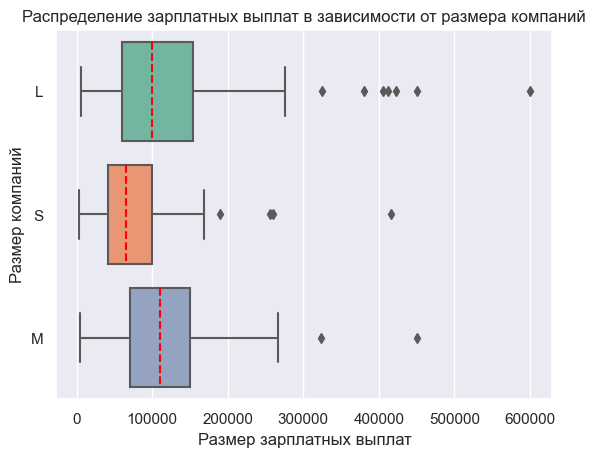

In [28]:
ax = sns.boxplot(df_salaries_1, x="salary_in_usd", y="company_size", orient="h", medianprops={"color": "red", "linestyle": "--"})
ax.set(xlabel="Размер зарплатных выплат", ylabel="Размер компаний")
plt.title("Распределение зарплатных выплат в зависимости от размера компаний")
plt.show()

Распределения зарплатных выплат в зависимости от размера компаний имеют отличия. Чтобы определить, являются ли эти отличия статистически значимыми, необходимо провести статистическое тестирование.

**8. Распределение зарплатных выплат в зависимости от местонахождения компаний.**

In [29]:
data_agg = df_salaries_1.groupby("company_location")["salary_in_usd"].describe().round(2)
print("Распределение зарпатных выплат в зависимости от местонахождения компаний")
data_agg

Распределение зарпатных выплат в зависимости от местонахождения компаний


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
AE,3.0,100000.00,30413.81,65000.0,90000.00,115000.0,117500.00,120000.0
AS,1.0,18053.00,NaN,18053.0,18053.00,18053.0,18053.00,18053.0
AT,4.0,72920.75,13332.78,61467.0,64003.50,69489.5,78406.75,91237.0
AU,3.0,108042.67,36337.91,86703.0,87064.00,87425.0,118712.50,150000.0
BE,2.0,85699.00,4179.00,82744.0,84221.50,85699.0,87176.50,88654.0
BR,3.0,18602.67,5555.76,12901.0,15904.00,18907.0,21453.50,24000.0
CA,28.0,100121.86,47080.71,52000.0,70518.00,81895.5,117374.75,225000.0
CH,2.0,64114.00,82352.48,5882.0,34998.00,64114.0,93230.00,122346.0
CL,1.0,40038.00,NaN,40038.0,40038.00,40038.0,40038.00,40038.0


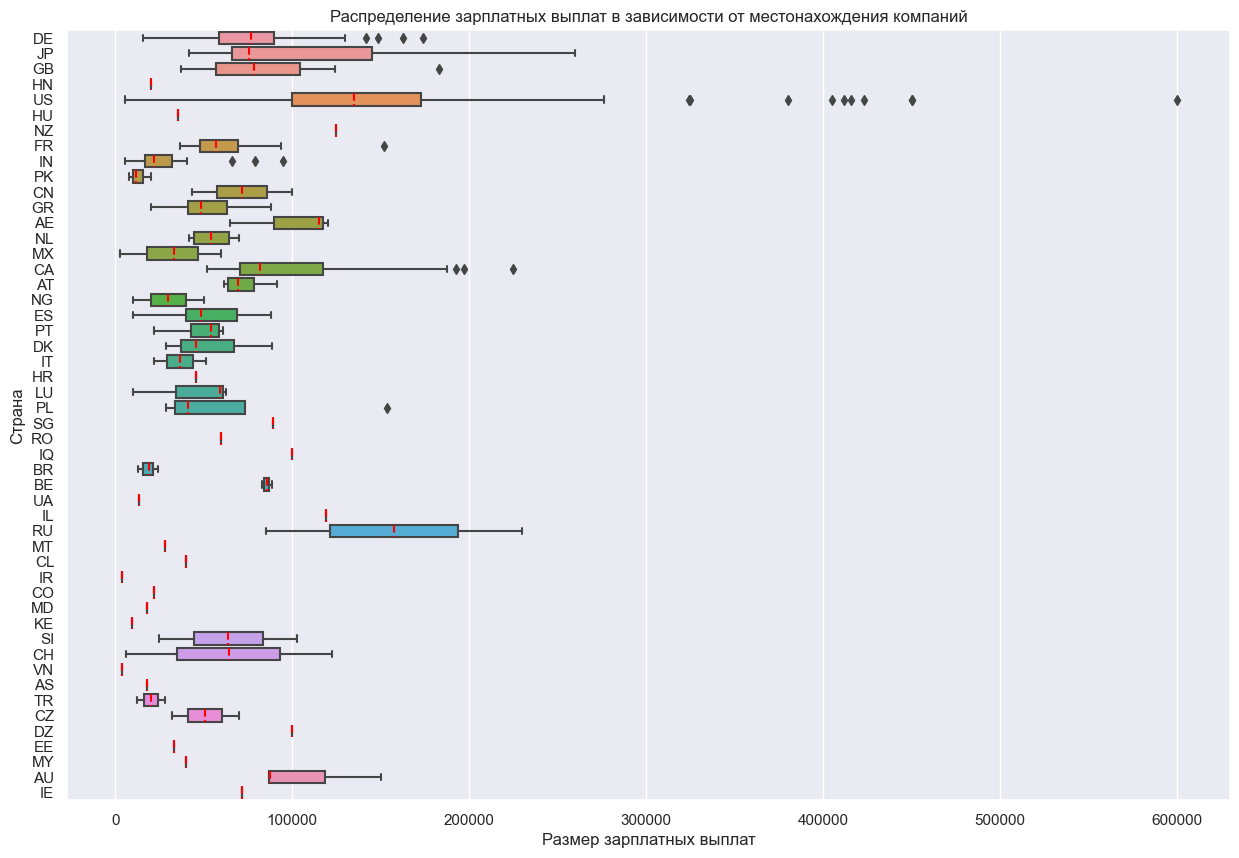

In [30]:
ax = plt.figure(figsize=(15,10))
ax = sns.boxplot(df_salaries_1, x="salary_in_usd", y="company_location", orient="h", medianprops={"color": "red", "linestyle": "--"})
ax.set(xlabel="Размер зарплатных выплат", ylabel="Страна")
plt.title("Распределение зарплатных выплат в зависимости от местонахождения компаний")
plt.show()

Распределения зарплатных выплат в зависимости от местонахождения компаний имеют отличия. Чтобы определить, являются ли эти отличия статистически значимыми, необходимо провести статистическое тестирование.

Далее, перейдем к статистическому анализу данных.

##### **2.2. Статистический анализ данных**

In [31]:
# Функция для принятия решения о нормальности
def decision_normality(p):
    print("p-value = {:.3f}".format(p))
    if p <= alpha:
        print("p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального".format(alpha))
    else:
        print("p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным".format(alpha))


# Функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print("p-value = {:.3f}".format(p))
    if p <= alpha:
        print("p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.".format(alpha))
    else:
        print("p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.".format(alpha))

##### **1. Наблюдается ли ежегодный рост зарплат у специалистов *Data Scientist*?**

**Сформулируем нулевую и альтернативные гипотезы:**

* *Нулевая гипотеза ($H_0$)*: средний размер заработных выплат специалистов *Data Scientist* в 2020 ($μ_1$), в 2021 ($μ_2$) и в 2022 годах ($μ_3$) *<u>не отличается</u>:*

$$ H_0 : μ_1 = μ_2 = μ_3$$

* *Альтернативная гипотеза ($H_1$)*: средний размер заработных выплат специалистов *Data Scientist* в 2020 ($μ_1$), в 2021 ($μ_2$) и в 2022 годах ($μ_3$) *<u>отличается</u>:*

$$ H_0 : μ_1 ≠ μ_2 ≠ μ_3 $$

**Проверка на нормальность:**

С помощью теста Шапиро-Уилка проверим, распределен ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

* *Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

* *Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [32]:
# Значения зарплатных выплат
data_scientist = df_salaries_1[(df_salaries_1["job_title"] == "Data Scientist") & (df_salaries_1["work_year"].isin([2020]))]
year_2020 = data_scientist.loc[data_scientist["work_year"]==2020, "salary_in_usd"]

data_scientist = df_salaries_1[(df_salaries_1["job_title"] == "Data Scientist") & (df_salaries_1["work_year"].isin([2021]))]
year_2021 = data_scientist.loc[data_scientist["work_year"]==2021, "salary_in_usd"]

data_scientist = df_salaries_1[(df_salaries_1["job_title"] == "Data Scientist") & (df_salaries_1["work_year"].isin([2022]))]
year_2022 = data_scientist.loc[data_scientist["work_year"]==2022, "salary_in_usd"]

# Проводим тест Шапиро-Уилка
print("Для специалистов Data Scientist в 2020 году:")
result = stats.shapiro(year_2020)
decision_normality(result[1])

print("Для специалистов Data Scientist в 2021 году:")
result = stats.shapiro(year_2021)
decision_normality(result[1])

print("Для специалистов Data Scientist в 2022 году:")
result = stats.shapiro(year_2022)
decision_normality(result[1])

Для специалистов Data Scientist в 2020 году:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для специалистов Data Scientist в 2021 году:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для специалистов Data Scientist в 2022 году:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест:**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

* Какой тип у признака «Размер зарплатных выплат»? - Количественный.
* Сколько сравниваемых групп? - Три.
* Группы зависимы? - Нет.
* Признак распределён по нормальному закону? - Нет.

Чтобы проверить нашу гипотезу, можно использовать *критерий Краскела - Уоллиса*.

**Проведём тест:**

In [33]:
# Проводим тест
_, p = stats.kruskal(year_2020, year_2021, year_2022)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**

Отвергаем нулевую гипотезу в пользу альтернативной. Cредний размер заработных выплат специалистов *Data Scientist* в 2020, в 2021 и в 2022 годах отличается, а именно растет из года в год, соответственно, статистическая значимость гипотезы подтверждена.

##### **2. Как соотносятся зарплаты *Data Scientist* и *Data Engineer* в 2022 году?**

**Сформулируем нулевую и альтернативные гипотезы:**

* *Нулевая гипотеза ($H_0$)*: размер зарплат специалистов *Data Scientist* ($μ_1$) статистически меньше или равен размеру зарплат специалистов *Data Engineer* ($μ_2$) в 2022 году.

$$ H_0 : μ_1 ≤ μ_2$$

* *Альтернативная гипотеза ($H_1$)*: размер зарплат специалистов *Data Scientist* ($μ_1$) статистически больше размера зарплат специалистов *Data Engineer* ($μ_2$) в 2022 году.

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность:**

С помощью теста Шапиро-Уилка проверим, распределен ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

* *Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

* *Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [34]:
# Значения зарплатных выплат
data_scientist = df_salaries_1[(df_salaries_1["job_title"] == "Data Scientist") & (df_salaries["work_year"].isin([2022]))]
salary_ds = data_scientist.loc[data_scientist["work_year"]==2022, "salary_in_usd"]

data_engineer = df_salaries_1[(df_salaries_1["job_title"] == "Data Engineer") & (df_salaries["work_year"].isin([2022]))]
salary_de = data_engineer.loc[data_engineer["work_year"]==2022, "salary_in_usd"]

# Проводим тест Шапиро-Уилка
print("Для специалистов Data Scientist в 2022 году:")
result = stats.shapiro(salary_ds)
decision_normality(result[1])

print("Для специалистов Data Engineer в 2022 году:")
result = stats.shapiro(salary_de)
decision_normality(result[1])

Для специалистов Data Scientist в 2022 году:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для специалистов Data Engineer в 2022 году:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест:**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

* Какой тип у признака «Размер зарплатных выплат»? - Количественный.
* Сколько сравниваемых групп? - Две.
* Группы зависимы? - Нет.
* Признак распределён по нормальному закону? - Нет.

Чтобы проверить нашу гипотезу, можно использовать *U-КРИТЕРИЙ МАННА - УИТНИ*.

**Проведем тест:**

In [37]:
# Проводим тест
_, p = stats.mannwhitneyu(salary_ds, salary_de, alternative="greater")
decision_hypothesis(p)

p-value = 0.160
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:**

У нас нет оснований отвергнуть нулевую гипотезу, а значит размер зарплат специалистов *Data Scientist* статистически меньше или равен размеру зарплат специалистов *Data Engineer* в 2022 году.

##### **3. Как соотносятся зарплаты специалистов *Data Scientist* в компаниях различных размеров?**

**Сформулируем нулевую и альтернативные гипотезы:**

* *Нулевая гипотеза ($H_0$)*: размер зарплат специалистов *Data Scientist* в зависимости от размера маленьких ($μ_1$), средних ($μ_2$) и больших ($μ_3$) компаний *<u>не отличается</u>.*

$$ H_0 : μ_1 = μ_2 = μ_3 $$

* *Альтернативная гипотеза ($H_1$)*: размер зарплат специалистов *Data Scientist* в зависимости от размера маленьких ($μ_1$), средних ($μ_2$) и больших ($μ_3$) компаний *<u>отличается</u>.*

$$ H_0 : μ_1 ≠ μ_2 ≠ μ_3 $$

**Проверка на нормальность:**

С помощью теста Шапиро-Уилка проверим, распределен ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

* *Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

* *Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [38]:
# Значения зарплатных выплат
data_scientist = df_salaries_1[(df_salaries_1["job_title"] == "Data Scientist")]
company_small = data_scientist.loc[data_scientist["company_size"]=="S", "salary_in_usd"]
company_medium = data_scientist.loc[data_scientist["company_size"]=="M", "salary_in_usd"]
company_large = data_scientist.loc[data_scientist["company_size"]=="L", "salary_in_usd"]

# Проводим тест Шапиро-Уилка
print("Для маленьких компаний:")
result = stats.shapiro(company_small)
decision_normality(result[1])

print("Для средних компаний:")
result = stats.shapiro(company_medium)
decision_normality(result[1])

print("Для крупных компаний:")
result = stats.shapiro(company_large)
decision_normality(result[1])

Для маленьких компаний:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для средних компаний:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для крупных компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест:**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

* Какой тип у признака «Размер компаний»? - Количественный.
* Сколько сравниваемых групп? - Три.
* Группы зависимы? - Нет.
* Признак распределён по нормальному закону? - Нет.

Чтобы проверить нашу гипотезу, можно использовать *критерий Краскела - Уоллиса*.

**Проведём тест:**

In [39]:
# Проводим тест
_, p = stats.kruskal(company_small, company_medium, company_large)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**

Отвергаем нулевую гипотезу в пользу альтернативной, а значит размер зарплат специалистов *Data Scientist* в зависимости от размера компаний *<u>отличается</u>.*

##### **4. Есть ли связь между наличием должностей *Data Scientist* и *Data Engineer* и размером компании?**

**Сформулируем нулевую и альтернативные гипотезы:**

* *Нулевая гипотеза*: между специалистами *Data Scientist* и *Data Engineer* и размером компании нет взаимосвязи - *<u>признаки независимы</u>*.

* *Альтернативная гипотеза*: между специалистами *Data Scientist* и *Data Engineer* и размером компании есть взаимосвязь - *<u>признаки взаимосвязаны</u>*.

**Выберем подходящий статистический тест:**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

* Какой тип у признака «Специалист»? - Категориальный.
* Сколько сравниваемых групп? - Две.
* Проверяется независимость групп? - Да.

Для проверки нашей гипотезы можно использовать *Критерий хи-квадрат*.

In [40]:
# Вычисляем таблицу сопряжённости
data_cross = df_salaries_1[(df_salaries_1["job_title"] == "Data Scientist") | (df_salaries["job_title"] == "Data Engineer")]
table = pd.crosstab(data_cross["job_title"], df_salaries_1["company_size"])
table

company_size,L,M,S
job_title,,,
Data Engineer,34,81,6
Data Scientist,43,66,21


**Проведем тест:**

In [41]:
# Проводим тест
_, p, _, _ = stats.chi2_contingency(table)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**

Отвергаем нулевую гипотезу в пользу альтернативной, а значит существует статистически значимая взаимосвязь между специалистами *Data Scientist* и *Data Engineer* и размером компании.

#### **Дополнительные исследования:**

##### **5. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist, а именно выросла ли зарплата у специалистов Data Scientist в 2022 году по сравнению с 2021 годом?**

**Сформулируем нулевую и альтернативные гипотезы:**

* *Нулевая гипотеза ($H_0$)*: средний размер заработных выплат специалистов *Data Scientist* в 2022 году ($μ_1$) статистически меньше или равен среднему размеру заработных выплат специалистов *Data Scientist* в 2021 году ($μ_2$).

$$ H_0 : μ_1 ≤ μ_2$$

* *Альтернативная гипотеза ($H_1$)*: средний размер заработных выплат специалистов *Data Scientist* в 2022 году ($μ_1$) статистически больше, чем средний размер заработных выплат специалистов *Data Scientist* в 2021 году ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность:**

С помощью теста Шапиро-Уилка проверим, распределен ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

* *Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

* *Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [44]:
# Значения зарплатных выплат
data_scientist = df_salaries[(df_salaries["job_title"] == "Data Scientist") & (df_salaries["work_year"].isin([2022]))]
year_2022 = data_scientist.loc[data_scientist["work_year"]==2022, "salary_in_usd"]

data_scientist = df_salaries[(df_salaries["job_title"] == "Data Scientist") & (df_salaries["work_year"].isin([2021]))]
year_2021 = data_scientist.loc[data_scientist["work_year"]==2021, "salary_in_usd"]

# Проводим тест Шапиро-Уилка
print("Для специалистов Data Scientist в 2022 году:")
result = stats.shapiro(year_2022)
decision_normality(result[1])

print("Для специалистов Data Scientist в 2021 году:")
result = stats.shapiro(year_2021)
decision_normality(result[1])

Для специалистов Data Scientist в 2022 году:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для специалистов Data Scientist в 2021 году:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест:**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

* Какой тип у признака «Размер зарплатных выплат»? - Количественный.
* Сколько сравниваемых групп? - Две.
* Группы зависимы? - Нет.
* Признак распределён по нормальному закону? - Да.

Чтобы проверить нашу гипотезу, можно использовать *ДВУХВЫБОРОЧНЫЙ T-КРИТЕРИЙ* для сравнения средних значений распределений.

**Проведем тест:**

In [45]:
# Проводим тест
_, p = stats.ttest_ind(year_2022, year_2021, alternative="greater")
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**

Отвергаем нулевую гипотезу в пользу альтернативной. Средний размер заработных выплат специалистов *Data Scientist* в 2022 году статистически больше, чем средний размер заработных выплат специалистов *Data Scientist* в 2021 году.

##### **6. Наблюдается ли ежегодный рост зарплат у специалистов *Data Engineer*, а именно выросла ли зарплата у специалистов *Data Engineer* в 2022 году по сравнению с 2021 годом?**

**Сформулируем нулевую и альтернативные гипотезы:**

* *Нулевая гипотеза ($H_0$)*: средний размер заработных выплат специалистов *Data Engineer* в 2022 году ($μ_1$) статистически меньше или равен среднему размеру заработных выплат специалистов *Data Engineer* в 2021 году ($μ_2$).

$$ H_0 : μ_1 ≤ μ_2$$

* *Альтернативная гипотеза ($H_1$)*: средний размер заработных выплат специалистов *Data Engineer* в 2022 году ($μ_1$) статистически больше, чем средний размер заработных выплат специалистов *Data Engineer* в 2021 году ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность:**

С помощью теста Шапиро-Уилка проверим, распределен ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

* *Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

* *Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [46]:
# Значения зарплатных выплат
data_engineer = df_salaries_1[(df_salaries_1["job_title"] == "Data Engineer") & (df_salaries["work_year"].isin([2022]))]
year_2022 = data_engineer.loc[data_engineer["work_year"]==2022, "salary_in_usd"]

data_engineer = df_salaries_1[(df_salaries_1["job_title"] == "Data Engineer") & (df_salaries["work_year"].isin([2021]))]
year_2021 = data_engineer.loc[data_engineer["work_year"]==2021, "salary_in_usd"]

# Проводим тест Шапиро-Уилка
print("Для специалистов Data Engineer в 2022 году:")
result = stats.shapiro(year_2022)
decision_normality(result[1])

print("Для специалистов Data Engineer в 2021 году:")
result = stats.shapiro(year_2021)
decision_normality(result[1])

Для специалистов Data Engineer в 2022 году:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для специалистов Data Engineer в 2021 году:
p-value = 0.253
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест:**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

* Какой тип у признака «Размер зарплатных выплат»? - Количественный.
* Сколько сравниваемых групп? - Две.
* Группы зависимы? - Нет.
* Признак распределён по нормальному закону? - Нет.

Чтобы проверить нашу гипотезу, можно использовать *U-КРИТЕРИЙ МАННА - УИТНИ*.

**Проведем тест:**

In [47]:
# Проводим тест
_, p = stats.mannwhitneyu(year_2022, year_2021, alternative="greater")
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**

Отвергаем нулевую гипотезу в пользу альтернативной. Средний размер заработных выплат специалистов *Data Engineer* в 2022 году статистически больше, чем средний размер заработных выплат специалистов *Data Engineer* в 2021 году **- результат получился такое же, как и в ранее проведенном исследовании, касающегося заработных выплат специалистов *Data Scientist*.**

##### **7. Как соотносятся зарплаты специалистов *Data Engineer* в компаниях различных размеров, а именно отличается ли зарплата специалистов *Data Engineer* в маленьких, средних и больших компаниях?**

**Сформулируем нулевую и альтернативные гипотезы:**

* *Нулевая гипотеза ($H_0$)*: размер зарплат специалистов *Data Engineer* в зависимости от размера маленьких ($μ_1$), средних ($μ_2$) и больших ($μ_3$) компаний *<u>не отличается</u>.*

$$ H_0 : μ_1 = μ_2 = μ_3 $$

* *Альтернативная гипотеза ($H_1$)*: размер зарплат специалистов *Data Engineer* в зависимости от размера маленьких ($μ_1$), средних ($μ_2$) и больших ($μ_3$) компаний *<u>отличается</u>.*

$$ H_0 : μ_1 ≠ μ_2 ≠ μ_3 $$

**Проверка на нормальность:**

С помощью теста Шапиро-Уилка проверим, распределен ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

* *Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

* *Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [48]:
# Значения зарплатных выплат
data_engineer = df_salaries_1[(df_salaries_1["job_title"] == "Data Engineer")]
company_small = data_engineer.loc[data_engineer["company_size"]=="S", "salary_in_usd"]
company_medium = data_engineer.loc[data_engineer["company_size"]=="M", "salary_in_usd"]
company_large = data_engineer.loc[data_engineer["company_size"]=="L", "salary_in_usd"]

# Проводим тест Шапиро-Уилка
print("Для маленьких компаний:")
result = stats.shapiro(company_small)
decision_normality(result[1])

print("Для средних компаний:")
result = stats.shapiro(company_medium)
decision_normality(result[1])

print("Для крупных компаний:")
result = stats.shapiro(company_large)
decision_normality(result[1])

Для маленьких компаний:
p-value = 0.606
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для средних компаний:
p-value = 0.085
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для крупных компаний:
p-value = 0.109
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест:**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

* Какой тип у признака «Размер зарплатных выплат»? - Количественный.
* Сколько сравниваемых групп? - Три.
* Группы зависимы? - Нет.
* Признак распределён по нормальному закону? - Да.

Чтобы проверить нашу гипотезу, можно использовать *ОДНОФАКТОРНЫЙ ДИСПЕРСИОННЫЙ АНАЛИЗ (ANOVA)* для сравнения средних значений распределений.

**Проведем тест:**

In [49]:
# Проводим тест
_, p = stats.f_oneway(company_small, company_medium, company_large)
decision_hypothesis(p)

p-value = 0.032
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**

Отвергаем нулевую гипотезу в пользу альтернативной, а значит размер зарплат специалистов *Data Engineer* в зависимости от размера компаний *<u>отличается</u>* **- результат получился такое же, как и в ранее проведенном исследовании, касающегося зарплат специалистов *Data Scientist*.**

#### **3. Итоговые результаты исследования**
    
* Средний размер заработных выплат специалистов *Data Scientist* в 2020, в 2021 и в 2022 годах отличается, а именно растет из года в год.
* Размер зарплат специалистов *Data Scientist* статистически меньше или равен размеру зарплат специалистов *Data Engineer* в 2022 году, т.е. нет оснований утверждать, что зарплата специалистов *Data Scientist* больше, чем зарплата специалистов *Data Engineer*.
* Размер зарплат специалистов *Data Scientist* в зависимости от размера компаний *отличается*.
* Существует статистически значимая взаимосвязь между специалистами *Data Scientist* и *Data Engineer* и размером компании.
* Средний размер заработных выплат специалистов *Data Scientist* в 2022 году статистически больше, чем средний размер заработных выплат специалистов *Data Scientist* в 2021 году.
* Средний размер заработных выплат специалистов *Data Engineer* в 2022 году статистически больше, чем средний размер заработных выплат специалистов *Data Engineer* в 2021 году.
* Размер зарплат специалистов *Data Engineer* в зависимости от размера компаний *отличается*.

Исходя из анализа данных, есть основания полагать, что на размер зарплатных выплат специалистов *Data Scientist* однозначно влияют следующие факторы:

* *experience_level -* опыт работы;
* *employment_type -* тип трудоустройства;
* *job_title -* роль, в которой соискатель работал в течение года;
* *company_location -* страна главного офиса работодателя или филиала по контракту;
* *company_size -* среднее количество людей, работавших в компании в течение года.